In [1]:
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot')

In [2]:
def select(query):
    
    conn = sqlite3.connect('./data/lending-club-loan-data/database2.sqlite')
    cursor = conn.cursor()
    temp_df = pd.DataFrame(cursor.execute(query).fetchall())
    temp_df.columns = list(map(lambda x: x[0], cursor.description))
    conn.close()
    
    return temp_df.copy()

In [3]:
def plot_results_all(targets,predictions,title,schema='a'):

    tn, fp, fn, tp = confusion_matrix(targets,predictions).ravel()

    N_pre = tn/(tn+fn)
    N_rec = tn/(tn+fp)
        
    P_pre = tp/(tp+fp)
    P_rec = tp/(tp+fn)

    pre = [N_pre,P_pre]
    rec = [N_rec,P_rec]
    
    if schema == 'a':
        color1 = '#0085f9'
        color2 = '#00176d'
        
    if schema == 'b':
        color1 = '#00ddff'
        color2 = '#00176d'
        
    if schema == 'c':
        color1 = '#00fff2'
        color2 = '#001e14'
    
    if schema == 'd':
        color1 = '#00ffb2'
        color2 = '#000c00'

    k = 0.05
    ax.bar([2+k,5+k],pre,color=color1)
    ax.bar([3-k,6-k],rec,color=color2)
    ax.set_xticks([2.5,5.5])
    ax.set_xticklabels(['Defaulted','Paid Off'],fontsize=14)
    ax.set_xlim([1,7])
    ax.set_ylim([0,1.3])
    ax.legend(['Precision','Recall'],fontsize=12)
    ax.set_title(title,fontsize=16)

    plt.tight_layout()

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [5]:
# 1: non-clustered categories
#2: clustered categories

features_train1 = select('select * from final_cat_features_train')
features_test1 = select('select * from final_cat_features_test')

features_train2 = select('select * from final_cluster_features_train')
features_test2 = select('select * from final_cluster_features_test')

targets_train = select('select * from final_targets_train')
targets_test = select('select * from final_targets_test')

In [6]:
# the alternative feature matrices differ only in how the categorical information is represented. we will use different
# training sets for different algorithms, based on which combinations seem to work best.

print(len(features_train1))
print(len(features_train2))
print(len(targets_train))

print(len(features_test1))
print(len(features_test2))
print(len(targets_test))

201894
201894
201894
50474
50474
50474


In [7]:
# for logistic regression: use SMOTE with 1:1 ratio. use non-clustered categories

LR_ratio = {0:targets_train.loan_status.sum(),
            1:targets_train.loan_status.sum()}

LR_features, LR_targets = SMOTE(ratio=LR_ratio,random_state=2).fit_sample(features_train1,targets_train.loan_status)

In [8]:
# for gaussian naive bayes: use ADASYN with 1:1 ratio. use clustered categories

GNB_ratio = {0:targets_train.loan_status.sum(),
             1:targets_train.loan_status.sum()}

GNB_features, GNB_targets = ADASYN(ratio=GNB_ratio,random_state=3).fit_sample(features_train2,targets_train.loan_status)

In [9]:
# for K-NN: use ADASYN with 1:1 ratio. use clustered categories (use a different random state than GNB)

KNN_ratio = {0:targets_train.loan_status.sum(),
             1:targets_train.loan_status.sum()}

KNN_features, KNN_targets = ADASYN(ratio=KNN_ratio,random_state=4).fit_sample(features_train2,targets_train.loan_status)

In [10]:
# for random forest: use under sampling with 13:10 ratio. use clustered categories

RF_ratio = {0:(-(targets_train-1).loan_status.sum()),
            1:int((-(targets_train-1).loan_status.sum())/(1.3))}

RF_features, RF_targets = RandomUnderSampler(ratio=RF_ratio,random_state=5).fit_sample(features_train2,targets_train.loan_status)

In [11]:
# LR: no hyperparameter adjustment (negligible effects)
# GNB: no hyperparameter adjustment (resampling is already done..this would be redundant)
# k-NN: use 30 neighbors
# RF: use 80 trees

LR = LogisticRegression().fit(LR_features,LR_targets)
GNB = GaussianNB().fit(GNB_features,GNB_targets)
KNN = KNeighborsClassifier(n_neighbors=30).fit(KNN_features,KNN_targets)
RF = RandomForestClassifier(n_estimators=80).fit(RF_features,RF_targets)

In [12]:
# individual performances on their respective training sets (the training set before resampling is applied)
# (it's the same training set throughout, but different features are used between algorithms)

print('LR TRAIN')
print(classification_report(targets_train,LR.predict(features_train1)))
print('GNB TRAIN')
print(classification_report(targets_train,GNB.predict(features_train2)))
print('k-NN TRAIN')
print(classification_report(targets_train,KNN.predict(features_train2)))
print('RF TRAIN')
print(classification_report(targets_train,RF.predict(features_train2)))

LR TRAIN
             precision    recall  f1-score   support

          0       0.28      0.62      0.38     35905
          1       0.89      0.65      0.75    165989

avg / total       0.78      0.64      0.68    201894

GNB TRAIN
             precision    recall  f1-score   support

          0       0.22      0.81      0.34     35905
          1       0.90      0.37      0.52    165989

avg / total       0.78      0.45      0.49    201894

k-NN TRAIN
             precision    recall  f1-score   support

          0       0.27      0.32      0.29     35905
          1       0.85      0.81      0.83    165989

avg / total       0.74      0.72      0.73    201894

RF TRAIN
             precision    recall  f1-score   support

          0       0.33      1.00      0.50     35905
          1       1.00      0.57      0.72    165989

avg / total       0.88      0.65      0.68    201894



In [13]:
# individual performances on the test set, using the respective features (non-clustered for LR, clustered for rest)

print('LR TRAIN')
print(classification_report(targets_test,LR.predict(features_test1)))
print('GNB TRAIN')
print(classification_report(targets_test,GNB.predict(features_test2)))
print('k-NN TRAIN')
print(classification_report(targets_test,KNN.predict(features_test2)))
print('RF TRAIN')
print(classification_report(targets_test,RF.predict(features_test2)))

LR TRAIN
             precision    recall  f1-score   support

          0       0.28      0.64      0.38      8804
          1       0.89      0.64      0.75     41670

avg / total       0.79      0.64      0.69     50474

GNB TRAIN
             precision    recall  f1-score   support

          0       0.21      0.82      0.33      8804
          1       0.90      0.35      0.50     41670

avg / total       0.78      0.43      0.47     50474

k-NN TRAIN
             precision    recall  f1-score   support

          0       0.24      0.31      0.27      8804
          1       0.85      0.80      0.82     41670

avg / total       0.74      0.71      0.72     50474

RF TRAIN
             precision    recall  f1-score   support

          0       0.23      0.77      0.36      8804
          1       0.91      0.47      0.62     41670

avg / total       0.79      0.52      0.57     50474



In [14]:
ensemble_train = pd.DataFrame()

In [15]:
ensemble_train['LR_predict'] = LR.predict(features_train1)
ensemble_train['GNB_predict'] = GNB.predict(features_train2)
ensemble_train['KNN_predict'] = KNN.predict(features_train2)
ensemble_train['RF_predict'] = RF.predict(features_train2)

In [16]:
# predict_proba returns an array of 2d arrays (probability of each class). we don't need both--that is redundant information
# since (each) = (1 - other). take the first (probability of default)

ensemble_train['LR_prob'] = LR.predict_proba(features_train1)[:,0]
ensemble_train['GNB_prob'] = GNB.predict_proba(features_train2)[:,0]
ensemble_train['KNN_prob'] = KNN.predict_proba(features_train2)[:,0]
ensemble_train['RF_prob'] = RF.predict_proba(features_train2)[:,0]

In [17]:
ensemble_train.head()

,LR_predict,GNB_predict,KNN_predict,RF_predict,LR_prob,GNB_prob,KNN_prob,RF_prob
0,1,1,0,1,0.243083,0.342829,0.633333,0.1250
1,0,0,1,0,0.669480,0.865439,0.266667,0.6875
2,1,1,1,1,0.246772,0.023095,0.200000,0.3000
3,1,1,1,1,0.253055,0.223870,0.133333,0.1625
4,1,1,0,0,0.289317,0.154595,0.600000,0.7625


In [18]:
ensemble_test = pd.DataFrame()

In [19]:
ensemble_test['LR_predict'] = LR.predict(features_test1)
ensemble_test['GNB_predict'] = GNB.predict(features_test2)
ensemble_test['KNN_predict'] = KNN.predict(features_test2)
ensemble_test['RF_predict'] = RF.predict(features_test2)

# Majority Vote between algorithms

The decision criteria (how many individual 'default' predictions are necessary for the ensemble to predict a default) is
varied from 4, 3, 2, 1. This varies how "strict" the ensemble is in predicting a default. Obvious tradeoffs between precision and recall.

In [20]:
def f(x):
    if x>0:
        return 1
    else:
        return 0

ensemble_train['major_vote'] = \
    ensemble_train['LR_predict']+ensemble_train['GNB_predict']+ensemble_train['KNN_predict']+ensemble_train['RF_predict']
ensemble_train['major_vote'] = ensemble_train['major_vote'].apply(f)

print('Ensemble Majority Vote - Train')
print('')
print(classification_report(targets_train,ensemble_train['major_vote']))
print('accuracy: '+str(accuracy_score(targets_train,ensemble_train['major_vote'])))

Ensemble Majority Vote - Train

             precision    recall  f1-score   support

          0       0.40      0.24      0.30     35905
          1       0.85      0.92      0.88    165989

avg / total       0.77      0.80      0.78    201894

accuracy: 0.801603811901


In [21]:
def f(x):
    if x>0:
        return 1
    else:
        return 0

ensemble_test['major_vote'] = \
    ensemble_test['LR_predict']+ensemble_test['GNB_predict']+ensemble_test['KNN_predict']+ensemble_test['RF_predict']
ensemble_test['major_vote'] = ensemble_test['major_vote'].apply(f)

print('Ensemble Majority Vote - Test')
print('')
print(classification_report(targets_test,ensemble_test['major_vote']))
print('accuracy: '+str(accuracy_score(targets_test,ensemble_test['major_vote'])))

Ensemble Majority Vote - Test

             precision    recall  f1-score   support

          0       0.33      0.23      0.27      8804
          1       0.85      0.90      0.87     41670

avg / total       0.76      0.78      0.77     50474

accuracy: 0.78448310021


In [22]:
# majority vote. if the vote is tied (2-2), vote positive (not a default)

def f(x):
    if x>1:
        return 1
    else:
        return 0

ensemble_train['major_vote'] = \
    ensemble_train['LR_predict']+ensemble_train['GNB_predict']+ensemble_train['KNN_predict']+ensemble_train['RF_predict']
ensemble_train['major_vote'] = ensemble_train['major_vote'].apply(f)

print('Ensemble Majority Vote - Train')
print('')
print(classification_report(targets_train,ensemble_train['major_vote']))
print('accuracy: '+str(accuracy_score(targets_train,ensemble_train['major_vote'])))

Ensemble Majority Vote - Train

             precision    recall  f1-score   support

          0       0.32      0.64      0.43     35905
          1       0.90      0.71      0.79    165989

avg / total       0.80      0.70      0.73    201894

accuracy: 0.696092999297


In [23]:
# majority vote. if the vote is tied (2-2), vote positive (not a default)

def f(x):
    if x>1:
        return 1
    else:
        return 0

ensemble_test['major_vote'] = \
    ensemble_test['LR_predict']+ensemble_test['GNB_predict']+ensemble_test['KNN_predict']+ensemble_test['RF_predict']
ensemble_test['major_vote'] = ensemble_test['major_vote'].apply(f)

print('Ensemble Majority Vote - Test')
print('')
print(classification_report(targets_test,ensemble_test['major_vote']))
print('accuracy: '+str(accuracy_score(targets_test,ensemble_test['major_vote'])))

Ensemble Majority Vote - Test

             precision    recall  f1-score   support

          0       0.28      0.60      0.38      8804
          1       0.89      0.67      0.76     41670

avg / total       0.78      0.66      0.70     50474

accuracy: 0.657823830091


In [24]:
# considerable increase in negative recall and drop in positive recall--this is expected
# small decrease in negative precision and increase in positive precision--this is also expected
# (we're loosening the standards for prediction of the negative class and increasing the standard for prediction
# of the positive class)

def f(x):
    if x>2:
        return 1
    else:
        return 0

ensemble_train['major_vote'] = \
    ensemble_train['LR_predict']+ensemble_train['GNB_predict']+ensemble_train['KNN_predict']+ensemble_train['RF_predict']
ensemble_train['major_vote'] = ensemble_train['major_vote'].apply(f)

print('Ensemble Majority Vote - Train')
print('')
print(classification_report(targets_train,ensemble_train['major_vote']))
print('accuracy: '+str(accuracy_score(targets_train,ensemble_train['major_vote'])))

Ensemble Majority Vote - Train

             precision    recall  f1-score   support

          0       0.28      0.88      0.42     35905
          1       0.95      0.50      0.66    165989

avg / total       0.83      0.57      0.62    201894

accuracy: 0.570244781915


In [25]:
def f(x):
    if x>2:
        return 1
    else:
        return 0

ensemble_test['major_vote'] = \
    ensemble_test['LR_predict']+ensemble_test['GNB_predict']+ensemble_test['KNN_predict']+ensemble_test['RF_predict']
ensemble_test['major_vote'] = ensemble_test['major_vote'].apply(f)

print('Ensemble Majority Vote - Test')
print('')
print(classification_report(targets_test,ensemble_test['major_vote']))
print('accuracy: '+str(accuracy_score(targets_test,ensemble_test['major_vote'])))

Ensemble Majority Vote - Test

             precision    recall  f1-score   support

          0       0.24      0.79      0.36      8804
          1       0.91      0.46      0.61     41670

avg / total       0.79      0.52      0.57     50474

accuracy: 0.517058287435


In [26]:
def f(x):
    if x>3:
        return 1
    else:
        return 0

ensemble_train['major_vote'] = \
    ensemble_train['LR_predict']+ensemble_train['GNB_predict']+ensemble_train['KNN_predict']+ensemble_train['RF_predict']
ensemble_train['major_vote'] = ensemble_train['major_vote'].apply(f)

print('Ensemble Majority Vote - Train')
print('')
print(classification_report(targets_train,ensemble_train['major_vote']))
print('accuracy: '+str(accuracy_score(targets_train,ensemble_train['major_vote'])))

Ensemble Majority Vote - Train

             precision    recall  f1-score   support

          0       0.23      1.00      0.37     35905
          1       1.00      0.26      0.41    165989

avg / total       0.86      0.39      0.40    201894

accuracy: 0.391363784956


In [27]:
def f(x):
    if x>3:
        return 1
    else:
        return 0

ensemble_test['major_vote'] = \
    ensemble_test['LR_predict']+ensemble_test['GNB_predict']+ensemble_test['KNN_predict']+ensemble_test['RF_predict']
ensemble_test['major_vote'] = ensemble_test['major_vote'].apply(f)

print('Ensemble Majority Vote - Test')
print('')
print(classification_report(targets_test,ensemble_test['major_vote']))
print('accuracy: '+str(accuracy_score(targets_test,ensemble_test['major_vote'])))

Ensemble Majority Vote - Test

             precision    recall  f1-score   support

          0       0.20      0.92      0.33      8804
          1       0.93      0.23      0.37     41670

avg / total       0.80      0.35      0.36     50474

accuracy: 0.348535879859


In [28]:
TH = [0,1,2,3,4]
precisions = []
recalls = []
accuracies = []

for t in TH:
    def f(x):
        if x<=(4-t):
            return 0
        else:
            return 1

    ensemble_train['major_vote'] = \
        ensemble_train['LR_predict']+ensemble_train['GNB_predict']+ensemble_train['KNN_predict']+ensemble_train['RF_predict']
    ensemble_train['major_vote'] = ensemble_train['major_vote'].apply(f)

    tn, fp, fn, tp = confusion_matrix(targets_train, ensemble_train['major_vote']).ravel()
    precisions.append(tn/(tn+fn))
    recalls.append(tn/(tn+fp))
    accuracies.append(accuracy_score(targets_train,ensemble_train['major_vote']))

In [29]:
TH = [0,1,2,3,4]
precisions1 = []
recalls1 = []
accuracies1 = []

for t in TH:
    def f(x):
        if x<=(4-t):
            return 0
        else:
            return 1

    ensemble_test['major_vote'] = \
        ensemble_test['LR_predict']+ensemble_test['GNB_predict']+ensemble_test['KNN_predict']+ensemble_test['RF_predict']
    ensemble_test['major_vote'] = ensemble_test['major_vote'].apply(f)

    tn, fp, fn, tp = confusion_matrix(targets_test, ensemble_test['major_vote']).ravel()
    precisions1.append(tn/(tn+fn))
    recalls1.append(tn/(tn+fp))
    accuracies1.append(accuracy_score(targets_test,ensemble_test['major_vote']))

Text(0.5,0,'Individual Prediction Count Threshold')

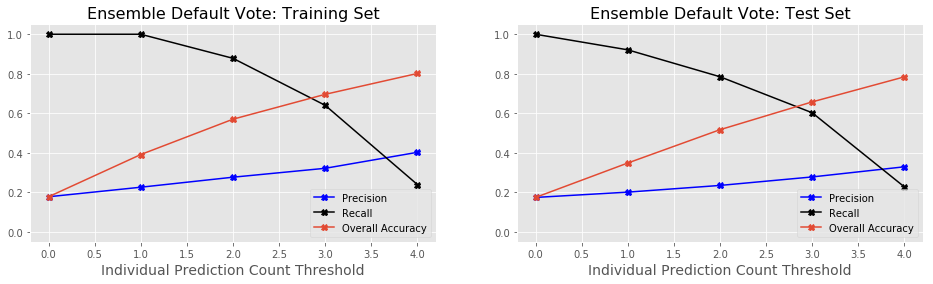

In [30]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,4))

ax1.plot(TH,precisions,'Xb-')
ax1.plot(TH,recalls,'Xk-')
ax1.plot(TH,accuracies,'X-')
ax1.set_ylim([-0.05,1.05])
ax1.legend(['Precision','Recall','Overall Accuracy'])
ax1.set_title('Ensemble Default Vote: Training Set',fontsize=16)
ax1.set_xlabel('Individual Prediction Count Threshold',fontsize=14)

ax2.plot(TH,precisions1,'Xb-')
ax2.plot(TH,recalls1,'Xk-')
ax2.plot(TH,accuracies1,'X-')
ax2.set_ylim([-0.05,1.05])
ax2.legend(['Precision','Recall','Overall Accuracy'])
ax2.set_title('Ensemble Default Vote: Test Set',fontsize=16)
ax2.set_xlabel('Individual Prediction Count Threshold',fontsize=14)

#plt.savefig('./report/ensemble-vote.jpg')

# Joint Probabilities of Default

$\space$


$$P_{ensemble}(Y = Default\space| \space X) = P_{LR}(Y = Default\space| \space X)P_{GNB}(Y = Default\space| \space X)P_{kNN}(Y = Default\space| \space X)P_{RF}(Y = Default\space| \space X)$$

$\space$

We can vary the threshhold on $P_{ensemble}(Y = Default\space| \space X)$ for the ensemble to predict a default.

In [31]:

ensemble_test['LR_prob'] = LR.predict_proba(features_test1)[:,0]
ensemble_test['GNB_prob'] = GNB.predict_proba(features_test2)[:,0]
ensemble_test['KNN_prob'] = KNN.predict_proba(features_test2)[:,0]
ensemble_test['RF_prob'] = RF.predict_proba(features_test2)[:,0]

In [74]:
# g() defines the decision criteria (threshold) for classifying a default
# ROC w negative instead of positive b/c of labeling choice we took..

tnr = []
precisionTRAIN = []
accuracyTRAIN = []
fnr = []
threshholds = [0.99,0.95,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0.05,0.02,0.01,0]

for t in threshholds:
    def g(x):
        if x > t:
            return 0
        else:
            return 1
    
    ensemble_train['joint_prob'] = \
        ensemble_train['LR_prob']*ensemble_train['GNB_prob']*ensemble_train['KNN_prob']*ensemble_train['RF_prob']

    ensemble_train['joint_predict'] = ensemble_train['joint_prob'].apply(g)

    tn, fp, fn, tp = confusion_matrix(targets_train, ensemble_train['joint_predict']).ravel()

    tnr.append(tn/(tn+fp))
    precisionTRAIN.append(tn/(tn+fn))
    accuracyTRAIN.append(accuracy_score(targets_train, ensemble_train['joint_predict']))
    fnr.append(fn/(fn+tp))

C:\Users\Pablo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in longlong_scalars


In [75]:
# g() defines the decision criteria (threshold) for classifying a default
# ROC w negative instead of positive b/c of labeling choice we took..

tnr_lr = []
fnr_lr = []

tnr_gnb = []
fnr_gnb = []

tnr_knn = []
fnr_knn = []

tnr_rf = []
fnr_rf = []

threshholds = [0.99,0.95,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0.05,0.02,0.01,0]

for t in threshholds:
    def g(x):
        if x > t:
            return 0
        else:
            return 1

    tn, fp, fn, tp = confusion_matrix(targets_train, ensemble_train['LR_prob'].apply(g)).ravel()
    tnr_lr.append(tn/(tn+fp))
    fnr_lr.append(fn/(fn+tp))
    
    tn, fp, fn, tp = confusion_matrix(targets_train, ensemble_train['GNB_prob'].apply(g)).ravel()
    tnr_gnb.append(tn/(tn+fp))
    fnr_gnb.append(fn/(fn+tp))
    
    tn, fp, fn, tp = confusion_matrix(targets_train, ensemble_train['KNN_prob'].apply(g)).ravel()
    tnr_knn.append(tn/(tn+fp))
    fnr_knn.append(fn/(fn+tp))
    
    tn, fp, fn, tp = confusion_matrix(targets_train, ensemble_train['RF_prob'].apply(g)).ravel()
    tnr_rf.append(tn/(tn+fp))
    fnr_rf.append(fn/(fn+tp))

Text(0.5,0,'Probability of False Alarm')

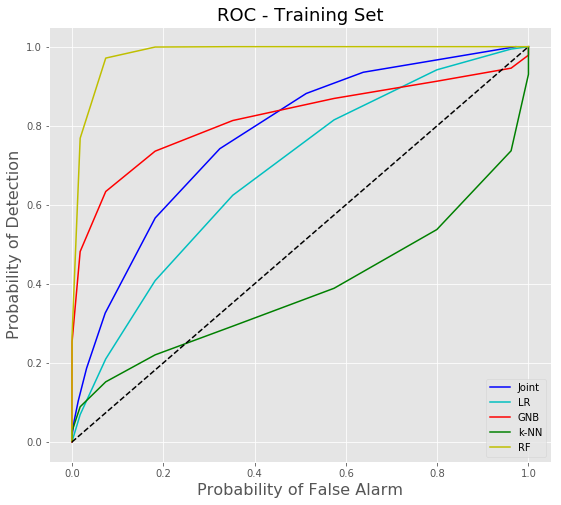

In [76]:
 

fig, ax = plt.subplots(1,1,figsize=(9,8))

ax.plot(fnr,tnr,'b')
ax.plot(fnr_lr,tnr_lr,'c')
ax.plot(fnr_lr,tnr_gnb,'r')
ax.plot(fnr_lr,tnr_knn,'g')
ax.plot(fnr_lr,tnr_rf,'y')
ax.legend(['Joint','LR','GNB','k-NN','RF'])
ax.plot([0,1],[0,1],'k--')
ax.set_xlim([-0.05,1.05])
ax.set_ylim([-0.05,1.05])
ax.set_title('ROC - Training Set',fontsize=18)
ax.set_ylabel('Probability of Detection',fontsize=16)
ax.set_xlabel('Probability of False Alarm',fontsize=16)

#plt.savefig('./report/ROC-train.jpg')

In [77]:
# g() defines the decision criteria (threshold) for classifying a default
# ROC w negative instead of positive b/c of labeling choice we took..

tnr0 = []
precisionTEST = []
accuracyTEST = []
fnr = []
threshholds = [0.99,0.95,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0.05,0.02,0.01,0]

for t in threshholds:
    def g(x):
        if x > t:
            return 0
        else:
            return 1
    
    ensemble_test['joint_prob'] = \
        ensemble_test['LR_prob']*ensemble_test['GNB_prob']*ensemble_test['KNN_prob']*ensemble_test['RF_prob']

    ensemble_test['joint_predict'] = ensemble_test['joint_prob'].apply(g)

    tn, fp, fn, tp = confusion_matrix(targets_test, ensemble_test['joint_predict']).ravel()

    tnr0.append(tn/(tn+fp))
    fnr.append(fn/(fn+tp))
    precisionTEST.append(tn/(tn+fn))
    accuracyTEST.append(accuracy_score(targets_test, ensemble_test['joint_predict']))

C:\Users\Pablo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in longlong_scalars


In [78]:
# g() defines the decision criteria (threshold) for classifying a default
# ROC w negative instead of positive b/c of labeling choice we took..

tnr_lr = []
fnr_lr = []

tnr_gnb = []
fnr_gnb = []

tnr_knn = []
fnr_knn = []

tnr_rf = []
fnr_rf = []

threshholds = [0.99,0.95,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0.05,0.02,0.01,0]

for t in threshholds:
    def g(x):
        if x > t:
            return 0
        else:
            return 1

    tn, fp, fn, tp = confusion_matrix(targets_test, ensemble_test['LR_prob'].apply(g)).ravel()
    tnr_lr.append(tn/(tn+fp))
    fnr_lr.append(fn/(fn+tp))
    
    tn, fp, fn, tp = confusion_matrix(targets_test, ensemble_test['GNB_prob'].apply(g)).ravel()
    tnr_gnb.append(tn/(tn+fp))
    fnr_gnb.append(fn/(fn+tp))
    
    tn, fp, fn, tp = confusion_matrix(targets_test, ensemble_test['KNN_prob'].apply(g)).ravel()
    tnr_knn.append(tn/(tn+fp))
    fnr_knn.append(fn/(fn+tp))
    
    tn, fp, fn, tp = confusion_matrix(targets_test, ensemble_test['RF_prob'].apply(g)).ravel()
    tnr_rf.append(tn/(tn+fp))
    fnr_rf.append(fn/(fn+tp))

Text(0.5,0,'Probability of False Alarm')

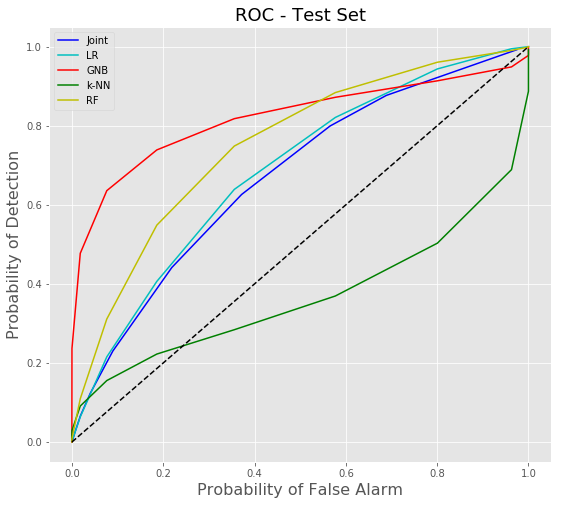

In [79]:
fig, ax = plt.subplots(1,1,figsize=(9,8))

ax.plot(fnr,tnr0,'b')
ax.plot(fnr_lr,tnr_lr,'c')
ax.plot(fnr_lr,tnr_gnb,'r')
ax.plot(fnr_lr,tnr_knn,'g')
ax.plot(fnr_lr,tnr_rf,'y')
ax.legend(['Joint','LR','GNB','k-NN','RF'])
ax.plot([0,1],[0,1],'k--')
ax.set_xlim([-0.05,1.05])
ax.set_ylim([-0.05,1.05])
ax.set_title('ROC - Test Set',fontsize=18)
ax.set_ylabel('Probability of Detection',fontsize=16)
ax.set_xlabel('Probability of False Alarm',fontsize=16)

#plt.savefig('./report/ROC-test.jpg')

In [81]:
precisionTEST

[nan,
 nan,
 nan,
 nan,
 0.33333333333333331,
 0.421875,
 0.43956043956043955,
 0.42931547619047616,
 0.39289597680318955,
 0.35167505641381702,
 0.29880815071126487,
 0.26248631147931251,
 0.22997745319086363,
 0.21196144657714802,
 0.17706792062752091]

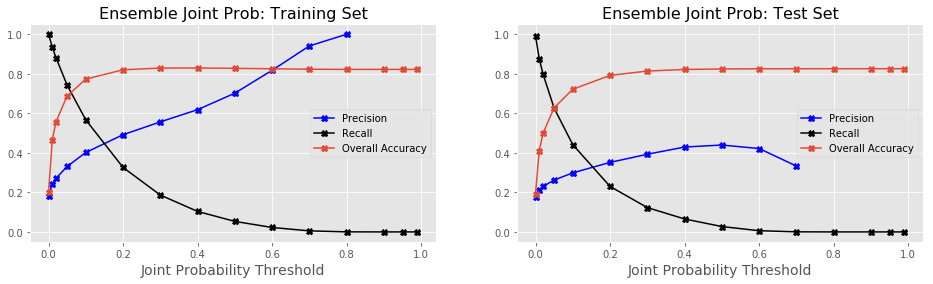

In [85]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,4))

ax1.plot(threshholds,precisionTRAIN,'Xb-')
ax1.plot(threshholds,tnr,'Xk-')
ax1.plot(threshholds,accuracyTRAIN,'X-')
ax1.set_ylim([-0.05,1.05])
ax1.legend(['Precision','Recall','Overall Accuracy'])
ax1.set_title('Ensemble Joint Prob: Training Set',fontsize=16)
ax1.set_xlabel('Joint Probability Threshold',fontsize=14)

ax2.plot(threshholds,precisionTEST,'Xb-')
ax2.plot(threshholds,tnr0,'Xk-')
ax2.plot(threshholds,accuracyTEST,'X-')
ax2.set_ylim([-0.05,1.05])
ax2.legend(['Precision','Recall','Overall Accuracy'])
ax2.set_title('Ensemble Joint Prob: Test Set',fontsize=16)
ax2.set_xlabel('Joint Probability Threshold',fontsize=14)

#plt.savefig('./report/ensemble-joint-probs.jpg')

# 'Stacking' Ensemble Approach

In [38]:
# now, train classifiers "in sequence" on the predicted probabilities

LR_ensemble = LogisticRegression().fit(ensemble_train[['LR_prob','GNB_prob','KNN_prob','RF_prob']],targets_train.loan_status)
GNB_ensemble = GaussianNB().fit(ensemble_train[['LR_prob','GNB_prob','KNN_prob','RF_prob']],targets_train.loan_status)
KNN_ensemble = KNeighborsClassifier(n_neighbors=30)\
    .fit(ensemble_train[['LR_prob','GNB_prob','KNN_prob','RF_prob']],targets_train.loan_status)
RF_ensemble = RandomForestClassifier(n_estimators=80)\
    .fit(ensemble_train[['LR_prob','GNB_prob','KNN_prob','RF_prob']],targets_train.loan_status)

In [39]:
# logistic regression, k-NN, RF all perform extremely well on the training set when running in sequence on the probabilities

print('LR ENSEMBLE TRAIN')
print(classification_report(targets_train,LR_ensemble.predict(ensemble_train[['LR_prob','GNB_prob','KNN_prob','RF_prob']])))
print('GNB ENSEMBLE TRAIN')
print(classification_report(targets_train,GNB_ensemble.predict(ensemble_train[['LR_prob','GNB_prob','KNN_prob','RF_prob']])))
print('KNN ENSEMBLE TRAIN')
print(classification_report(targets_train,KNN_ensemble.predict(ensemble_train[['LR_prob','GNB_prob','KNN_prob','RF_prob']])))
print('RF ENSEMBLE TRAIN')
print(classification_report(targets_train,RF_ensemble.predict(ensemble_train[['LR_prob','GNB_prob','KNN_prob','RF_prob']])))

LR ENSEMBLE TRAIN
             precision    recall  f1-score   support

          0       0.90      0.91      0.90     35905
          1       0.98      0.98      0.98    165989

avg / total       0.97      0.97      0.97    201894

GNB ENSEMBLE TRAIN
             precision    recall  f1-score   support

          0       0.65      0.80      0.72     35905
          1       0.95      0.91      0.93    165989

avg / total       0.90      0.89      0.89    201894

KNN ENSEMBLE TRAIN
             precision    recall  f1-score   support

          0       0.90      0.93      0.91     35905
          1       0.98      0.98      0.98    165989

avg / total       0.97      0.97      0.97    201894

RF ENSEMBLE TRAIN
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     35905
          1       1.00      1.00      1.00    165989

avg / total       1.00      1.00      1.00    201894



In [40]:
# not nearly as good performance on the test set.. esp recall again.

# GNB has repeatedly seems to do the best

print('LR ENSEMBLE TEST')
print(classification_report(targets_test,LR_ensemble.predict(ensemble_test.drop(['joint_prob','joint_predict','LR_predict','GNB_predict','KNN_predict','RF_predict','major_vote'],axis=1))))
print('GNB ENSEMBLE TEST')
print(classification_report(targets_test,GNB_ensemble.predict(ensemble_test.drop(['joint_prob','joint_predict','LR_predict','GNB_predict','KNN_predict','RF_predict','major_vote'],axis=1))))
print('KNN ENSEMBLE TEST')
print(classification_report(targets_test,KNN_ensemble.predict(ensemble_test.drop(['joint_prob','joint_predict','LR_predict','GNB_predict','KNN_predict','RF_predict','major_vote'],axis=1))))
print('RF ENSEMBLE TEST')
print(classification_report(targets_test,RF_ensemble.predict(ensemble_test.drop(['joint_prob','joint_predict','LR_predict','GNB_predict','KNN_predict','RF_predict','major_vote'],axis=1))))

LR ENSEMBLE TEST
             precision    recall  f1-score   support

          0       0.29      0.05      0.09      8804
          1       0.83      0.97      0.90     41670

avg / total       0.73      0.81      0.75     50474

GNB ENSEMBLE TEST
             precision    recall  f1-score   support

          0       0.34      0.26      0.30      8804
          1       0.85      0.89      0.87     41670

avg / total       0.76      0.78      0.77     50474

KNN ENSEMBLE TEST
             precision    recall  f1-score   support

          0       0.31      0.06      0.10      8804
          1       0.83      0.97      0.90     41670

avg / total       0.74      0.81      0.76     50474

RF ENSEMBLE TEST
             precision    recall  f1-score   support

          0       0.30      0.05      0.09      8804
          1       0.83      0.97      0.90     41670

avg / total       0.74      0.81      0.76     50474



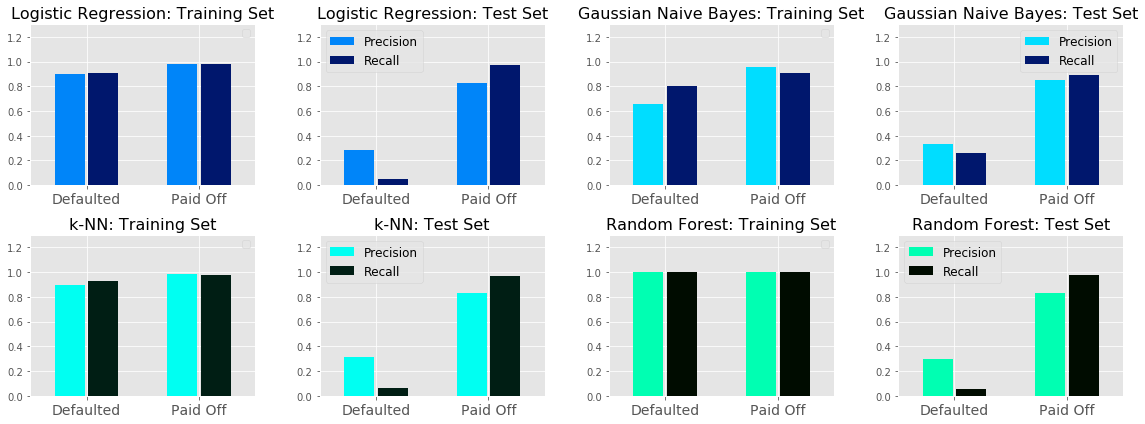

In [41]:
# 'stacking' on the predicted probabilities of each algorithm greatly improves training error, but the approach
# does not generalize to the test set.. the patterns found in the probabilities are specific to the data set 
# the models were trained on - do not generalize

fig = plt.figure(figsize=(16,6))

ax = fig.add_subplot(2,4,1)
plot_results_all(targets_train,LR_ensemble.predict(ensemble_train[['LR_prob','GNB_prob','KNN_prob','RF_prob']]),'Logistic Regression: Training Set')
ax.legend([])

ax = fig.add_subplot(2,4,2)
plot_results_all(targets_test,LR_ensemble.predict(ensemble_test[['LR_prob','GNB_prob','KNN_prob','RF_prob']]),'Logistic Regression: Test Set')

ax = fig.add_subplot(2,4,3)
plot_results_all(targets_train,GNB_ensemble.predict(ensemble_train[['LR_prob','GNB_prob','KNN_prob','RF_prob']]),'Gaussian Naive Bayes: Training Set','b')
ax.legend([])

ax = fig.add_subplot(2,4,4)
plot_results_all(targets_test,GNB_ensemble.predict(ensemble_test[['LR_prob','GNB_prob','KNN_prob','RF_prob']]),'Gaussian Naive Bayes: Test Set','b')

ax = fig.add_subplot(2,4,5)
plot_results_all(targets_train,KNN_ensemble.predict(ensemble_train[['LR_prob','GNB_prob','KNN_prob','RF_prob']]),'k-NN: Training Set','c')
ax.legend([])

ax = fig.add_subplot(2,4,6)
plot_results_all(targets_test,KNN_ensemble.predict(ensemble_test[['LR_prob','GNB_prob','KNN_prob','RF_prob']]),'k-NN: Test Set','c')

ax = fig.add_subplot(2,4,7)
plot_results_all(targets_train,RF_ensemble.predict(ensemble_train[['LR_prob','GNB_prob','KNN_prob','RF_prob']]),'Random Forest: Training Set','d')
ax.legend([])

ax = fig.add_subplot(2,4,8)
plot_results_all(targets_test,RF_ensemble.predict(ensemble_test[['LR_prob','GNB_prob','KNN_prob','RF_prob']]),'Random Forest: Test Set','d')

#plt.savefig('./report/stacking.jpg')

In [42]:
# the algorithms can find very particular patterns in the training set when using ensembles in sequence, but they do
# not generalize to the test set. again seems to reaffirm that there are not very clear "default patterns"....